In [14]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jre_utils.datapath import model_ready_data_paths
from jre_utils.config import asset_types, statistics, area_levels, period_cols

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay, r2_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [4]:
period = "yearly"
area_level = "municipality"
asset_type = "building"
statistic = "median"

granularity_columns = area_levels[area_level]["columns"]
group_by_columns = granularity_columns + [period_cols[period]]
display_columns = list(statistics[statistic].keys())

metric = asset_types[asset_type]["metric"]
metric_pct_chg = asset_types[asset_type]["metric_pct_chg"]
upcoming_metric_pct_chg = "Upcoming" + metric_pct_chg

In [8]:
df = pd.read_csv(model_ready_data_paths["xgb"])

In [5]:
y_columns = [upcoming_metric_pct_chg]

X_categorical_columns = ["Prefecture", "Municipality"]

X_basic_columns = [
    "year",
    "population",
    "Count",
    "taxable_income_per_taxpayer",
    "taxable_income_per_taxpayer_growth",
]

X_engineering_columns = [
    "net_migration_ratio",
    "taxable_income_growth",
    "new_dwellings_ratio",
    metric_pct_chg,
]

X_engineered_columns = [
    "net_migration_ratio_ma3",
    "net_migration_ratio_cumu3",
    "net_migration_ratio_lag1",
    "taxable_income_growth_ma3",
    "taxable_income_growth_cumu3",
    "taxable_income_growth_lag1",
    "new_dwellings_ratio_ma3",
    "new_dwellings_ratio_cumu3",
    "new_dwellings_ratio_lag1",
    "TradePricePctChg_ma3",
    "TradePricePctChg_cumu3",
    "TradePricePctChg_lag1",
]

X_columns = (
    X_categorical_columns
    + X_basic_columns
    + X_engineering_columns
    + X_engineered_columns
)

In [9]:
divide_year = 2020 # test_years = [2021]
train_df = df[df["year"] <= divide_year]
test_df = df[df["year"] > divide_year]

drop_columns = ["year", "Prefecture", "Municipality"]
X_train_df, X_test_df = train_df[X_columns].drop(columns=drop_columns), test_df[X_columns].drop(columns=drop_columns)
y_train_df, y_test_df = train_df[y_columns], test_df[y_columns]

In [10]:
X_train_df.shape, y_train_df.shape

((9749, 20), (9749, 1))

<Axes: ylabel='Frequency'>

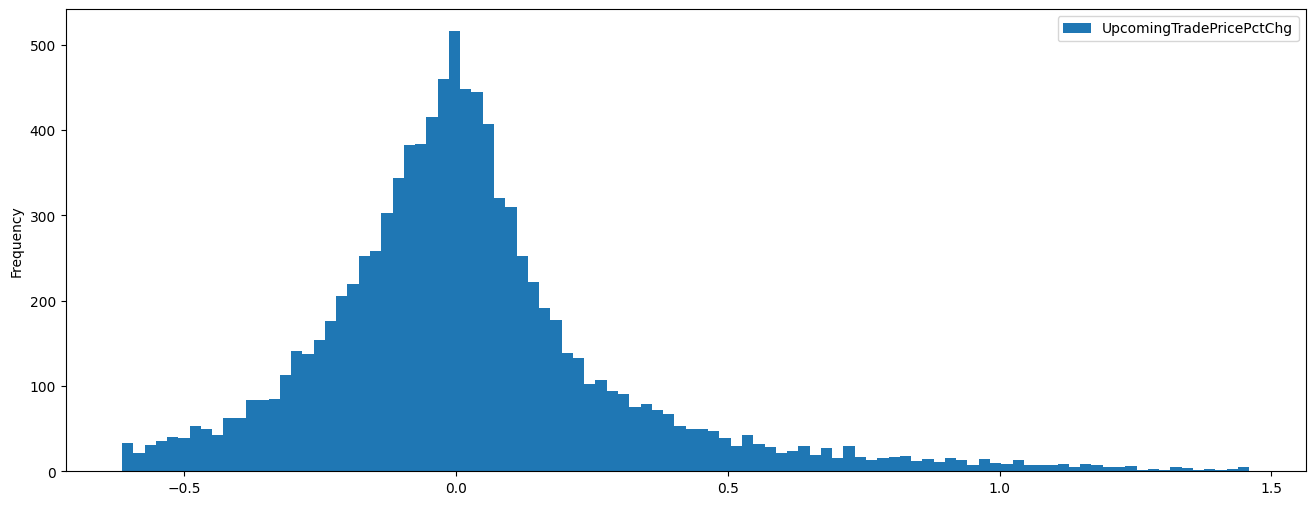

In [11]:
y_train_df.plot.hist(bins=100, figsize=(16, 6))

In [12]:
# xgb_regressor = XGBRegressor(tree_method="gpu_hist", gpu_id=0, predictor="gpu_predictor")
xgb_regressor = XGBRegressor(
    tree_method="hist", early_stopping_rounds=2, enable_categorical=True
)
xgb_regressor.fit(X_train_df, y_train_df, eval_set=[(X_test_df, y_test_df)])

y_train_pred = xgb_regressor.predict(X_train_df)
y_test_pred = xgb_regressor.predict(X_test_df)

print()
print(f"Train RMSE: {mean_squared_error(y_train_df, y_train_pred, squared=False):.4f}")
print(f"Test RMSE: {mean_squared_error(y_test_df, y_test_pred, squared=False):.4f}")

print(f"Train R2: {r2_score(y_train_df.values.squeeze(), y_train_pred):.4f}")
print(f"Test R2: {r2_score(y_test_df.values.squeeze(), y_test_pred):.4f}")

[0]	validation_0-rmse:0.28244
[1]	validation_0-rmse:0.27497
[2]	validation_0-rmse:0.26826
[3]	validation_0-rmse:0.26391
[4]	validation_0-rmse:0.26298
[5]	validation_0-rmse:0.26164
[6]	validation_0-rmse:0.26041
[7]	validation_0-rmse:0.26119

Train RMSE: 0.2251
Test RMSE: 0.2604
Train R2: 0.3816
Test R2: 0.2544


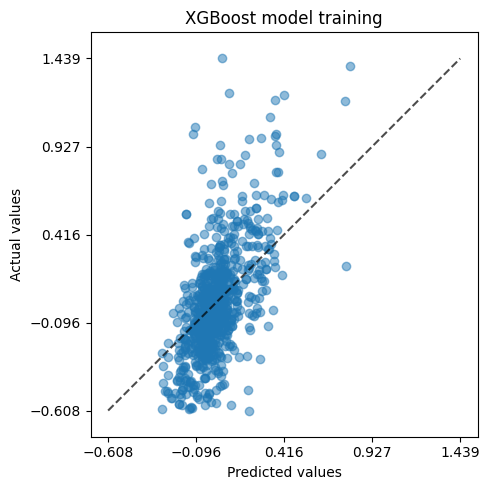

In [17]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_train_df.values.squeeze(),
    y_train_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model training")
plt.tight_layout()

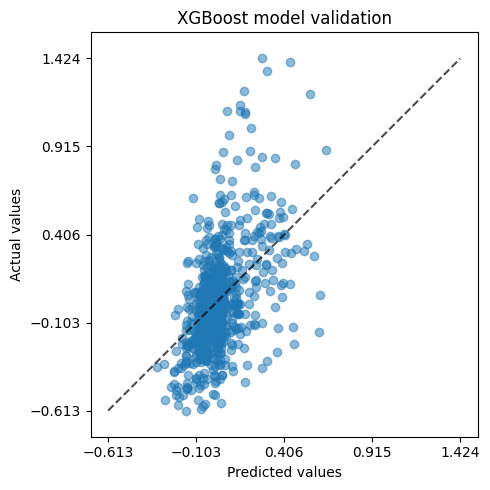

In [18]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test_df.values.squeeze(),
    y_test_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model validation")
plt.tight_layout()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

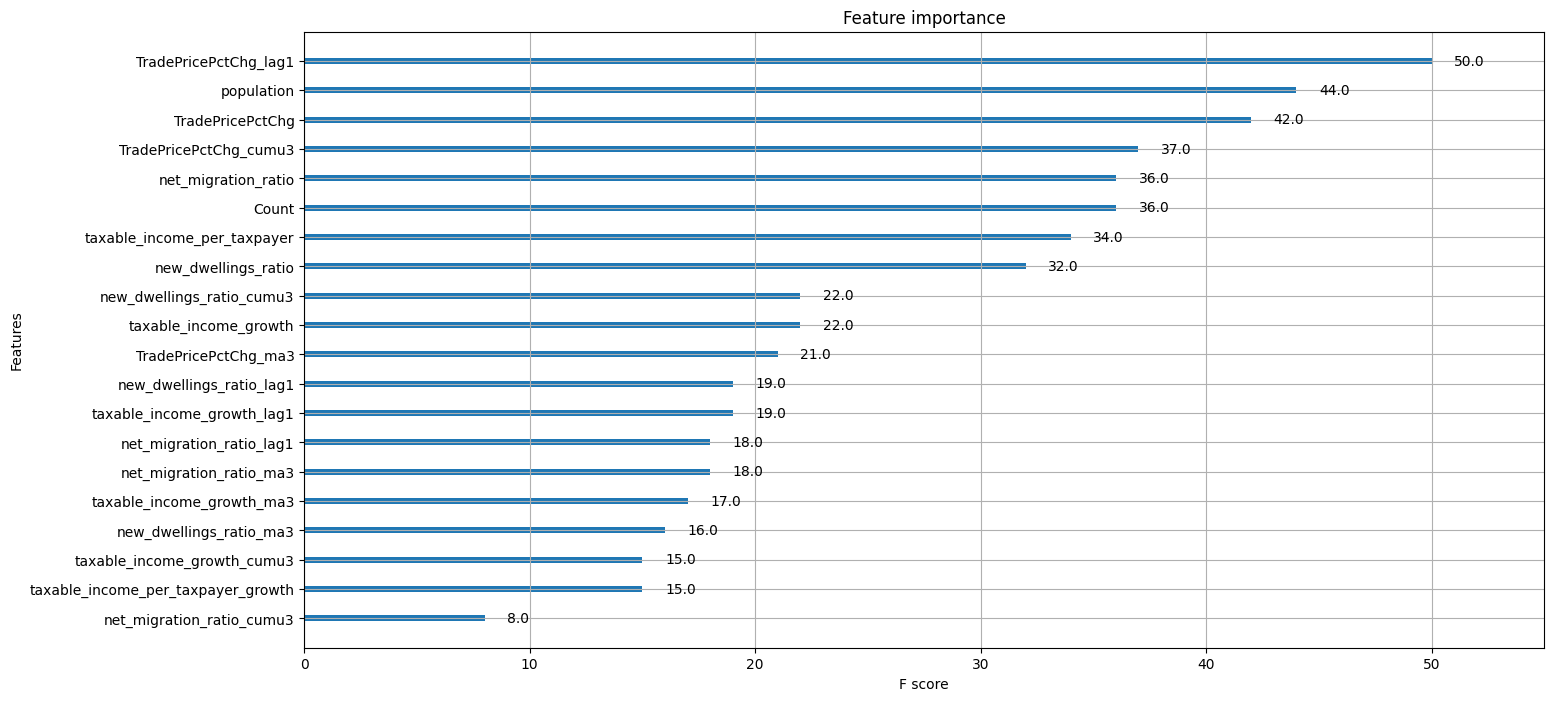

In [19]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_importance(xgb_regressor)